### Setting up a IPyKernel with several cores

In [1]:
import ipyparallel as ipp
cluster = ipp.Cluster(engines="mpi", n=4).start_and_connect_sync()

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

In [3]:
%%px
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
print(f"Process {rank} of {size} is running")

[stdout:0] Process 0 of 4 is running


[stdout:1] Process 1 of 4 is running


[stdout:3] Process 3 of 4 is running


[stdout:2] Process 2 of 4 is running


# Running a Wakefield simulation

Everything is exactly as example #002, with 2 main additions:
* To use the MPI kernel, the cell needs to start with `%%px`
* We need to set the flag `use_mpi=True` for the Grid and the Solver

In [4]:
%%px
import sys
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../wakis/')

from wakis import SolverFIT3D
from wakis import GridFIT3D 
from wakis import WakeSolver

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

Read and plot the geometry files:

In [5]:
%%px
# Embedded boundaries
stl_cavity = 'stl/cavity_vacuum.stl' 
stl_shell = 'stl/cavity_shell.stl'
stl_letters = 'stl/CEI_heart_courier_new.stl'

stl_solids = {'cavity': stl_cavity, 
              'shell': stl_shell,
              'letters' : stl_letters}

stl_materials = {'cavity': 'vacuum', 
                 'shell': [30, 1.0, 30],
                 'letters' : 'pec'}

stl_rotate = {'cavity': [0., 0., 0.],
                'shell': [0., 0., 0.],
                'letters' : [180, -90, 0]}

stl_translate = {'cavity': [0., 0., 0.],
                 'shell': [0., 0., 0.],
                 'letters' : [-10, 0, 35]}


stl_scale = {'cavity': [1., 1., 1.],
                 'shell': [1., 1., 1.],
                 'letters' : [0.7e-2, 0.4e-2, 0.4e-2]}

# Domain bounds
letters = pv.read(stl_letters) \
        .rotate_x(stl_rotate['letters'][0]) \
        .rotate_y(stl_rotate['letters'][1]) \
        .rotate_z(stl_rotate['letters'][2]) \
        .translate(stl_translate['letters']) \
        .scale(stl_scale['letters'])

surf = pv.read(stl_shell)+letters

Generate the simulation grid and inspect it:

In [7]:
%%px
# ---------- Domain setup ---------
# Number of mesh cells
Nx = 100
Ny = 100
Nz = 161
print(f"Total number of cells: {Nx*Ny*Nz}")

xmin, xmax, ymin, ymax, zmin, zmax = surf.bounds
# set grid and geometry
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz, 
                use_mpi=True,
                stl_solids=stl_solids, 
                stl_materials=stl_materials,
                stl_scale=stl_scale,
                stl_rotate=stl_rotate,
                stl_translate=stl_translate)

print(f"Process {rank}: Handling Z range {grid.zmin} to {grid.zmax} with {grid.Nz} cells")
print(f"Global domain goes from {grid.ZMIN} to {grid.ZMAX} with {grid.NZ} cells")

[stdout:0] Total number of cells: 1610000
MPI initialized for 0 of 4
Generating grid...
Importing stl solids...
Process 0: Handling Z range -0.25 to -0.04499999694526195 with 41 cells
Global domain goes from -0.25 to 0.550000011920929 with 160 cells


[stdout:1] Total number of cells: 1610000
MPI initialized for 1 of 4
Generating grid...
Importing stl solids...
Process 1: Handling Z range -0.05499999709427357 to 0.15500000603497027 with 42 cells
Global domain goes from -0.25 to 0.550000011920929 with 160 cells


[stdout:3] Total number of cells: 1610000
MPI initialized for 3 of 4
Generating grid...
Importing stl solids...
Process 3: Handling Z range 0.3450000088661909 to 0.550000011920929 with 41 cells
Global domain goes from -0.25 to 0.550000011920929 with 160 cells


[stdout:2] Total number of cells: 1610000
MPI initialized for 2 of 4
Generating grid...
Importing stl solids...
Process 2: Handling Z range 0.14500000588595868 to 0.3550000090152025 with 42 cells
Global domain goes from -0.25 to 0.550000011920929 with 160 cells


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

Define the wake and beam parameters:

In [9]:
%%px
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 

# Simualtion
wakelength = 30. #[m]
skip_cells = 10   # no. cells
results_folder = f'results_wl{int(wakelength)}/'
wake = WakeSolver(q=q, 
                  sigmaz=sigmaz, 
                  beta=beta,
                  xsource=xs, ysource=ys, 
                  xtest=xt, ytest=yt,
                  skip_cells=skip_cells, 
                  results_folder=results_folder,
                  Ez_file=results_folder+'Ez.h5')

Define the solver's boundary conditions, background

In [11]:
%%px
# ----------- Solver & Simulation ----------
# boundary conditions``
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec']

solver = SolverFIT3D(grid, wake,
                     bc_low=bc_low, bc_high=bc_high, 
                     bg='pec',      # backgorund material
                     use_stl=True,  # import geometry
                     use_mpi=True,
                     #use_gpu=False
                     )

[stdout:2] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 16.70033025741577 s


[stdout:3] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 16.542399168014526 s


[stdout:1] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 16.739434957504272 s


[stdout:0] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 16.409677267074585 s


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

Inspect the resulting material tensors, for example the permittivity $\varepsilon ^{-1}$

[output:1]

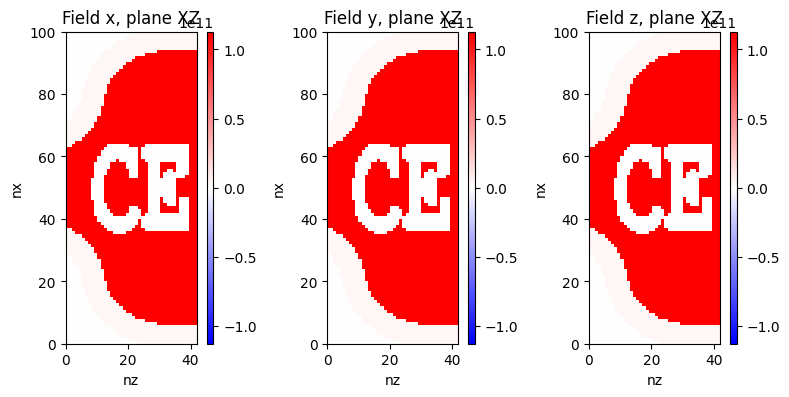

[output:0]

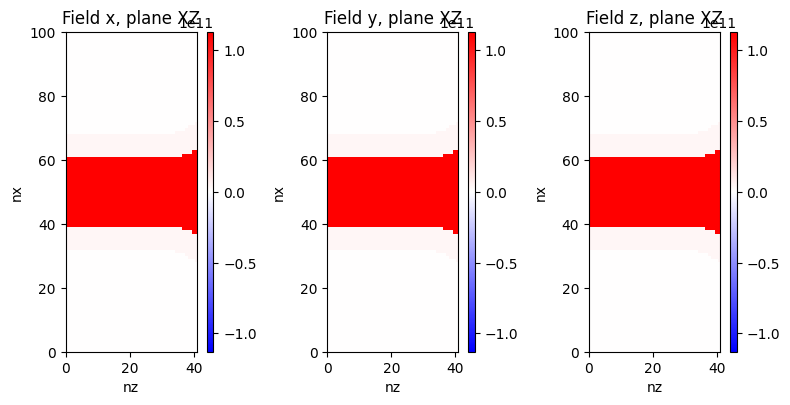

[output:2]

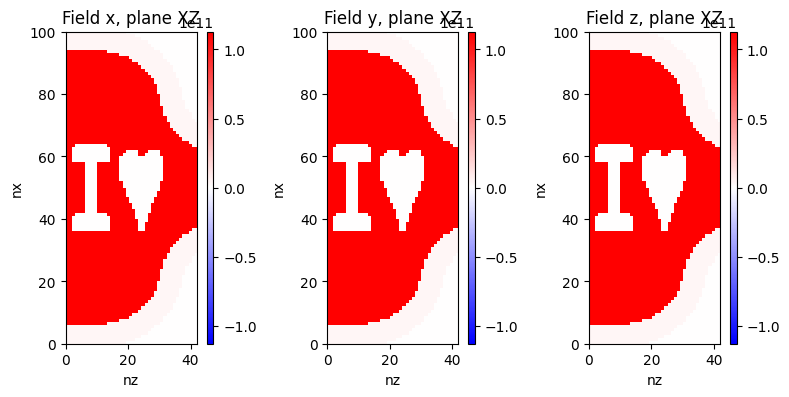

[output:3]

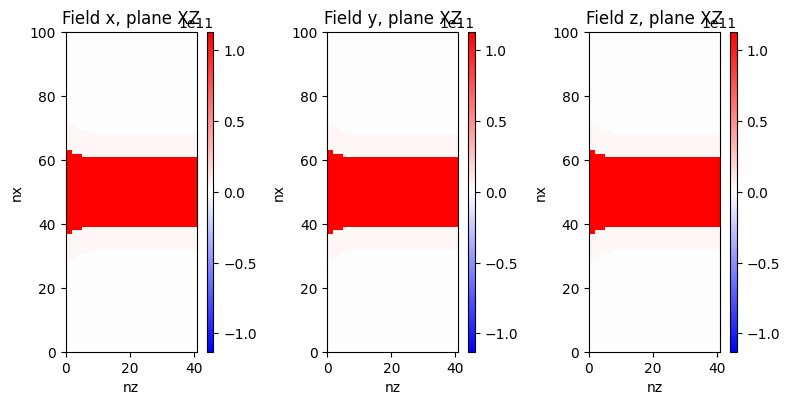

In [13]:
%%px
for n in range(size):
    if rank==n:
        solver.ieps.inspect(plane='XZ')

Prepare 2D plot settings for on-the-fly plots

In [14]:
%%px
# Plot settings
n=0
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('name', plt.cm.jet(np.linspace(0.05, 0.9))) # CST's colormap

plotkw2D = {'title':'img/E_z', 
            'add_patch':['cavity'], 'patch_alpha':0.9,
            'patch_reverse' : True, 
            'vmin':0, 'vmax':700,
            'interpolation' : 'gaussian',
            'cmap' : cmap,
            'plane': [slice(0, Nx), int(Ny/2), slice(0, Nz)]}

Run the wakefield simulation with dedicated routine `wakesolve`

In [15]:
%%px
# Wakefield Solver run
solver.wakesolve(wakelength=wakelength, 
                 plot=False, # turn False for speedup
                 plot_every=30, plot_until=3000, **plotkw2D
                 )

[stdout:2] Running electromagnetic time-domain simulation...


[stdout:1] Running electromagnetic time-domain simulation...


[stdout:3] Running electromagnetic time-domain simulation...


[stderr:3] 100%|██████████| 21369/21369 [26:52<00:00, 13.25it/s]


[stderr:1] 100%|██████████| 21369/21369 [26:52<00:00, 13.25it/s]


[stderr:2] 100%|██████████| 21369/21369 [26:52<00:00, 13.25it/s]


[stdout:0] Running electromagnetic time-domain simulation...
Reading h5 file results_wl30/Ez.h5
Calculating longitudinal wake potential WP(s)
Calculating transverse wake potential WPx, WPy...
Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...


[stderr:0]   0%|          | 0/21369 [00:00<?, ?it/s]

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

Let's plot our simulated wake and impedance:
* When using MPI, the results are only saved in `rank == 0`

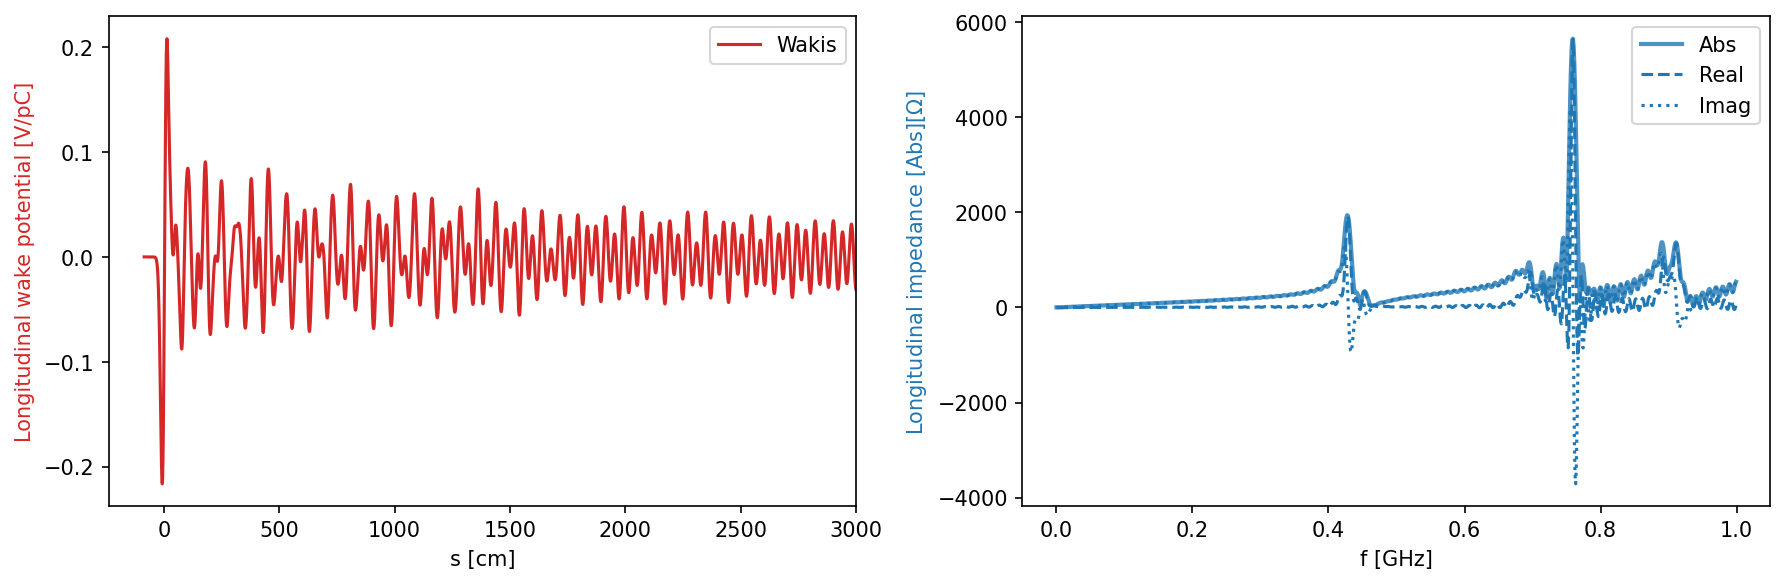

In [ ]:
%%px
if rank == 0:
    # Plot longitudinal wake potential and impedance
    fig1, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
    ax[0].plot(wake.s*1e2, wake.WP, c='tab:red', lw=1.5, label='Wakis')
    ax[0].set_xlabel('s [cm]')
    ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
    ax[0].legend()
    ax[0].set_xlim(xmax=wakelength*1e2)

    ax[1].plot(wake.f*1e-9, np.abs(wake.Z), c='tab:blue', alpha=0.8, lw=2, label='Abs')
    ax[1].plot(wake.f*1e-9, np.real(wake.Z), ls='--', c='tab:blue', lw=1.5, label='Real')
    ax[1].plot(wake.f*1e-9, np.imag(wake.Z), ls=':', c='tab:blue', lw=1.5, label='Imag')
    ax[1].set_xlabel('f [GHz]')
    ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
    ax[1].legend()

    fig1.tight_layout()
    fig1.savefig(results_folder+'longitudinal.png')
    #plt.show()


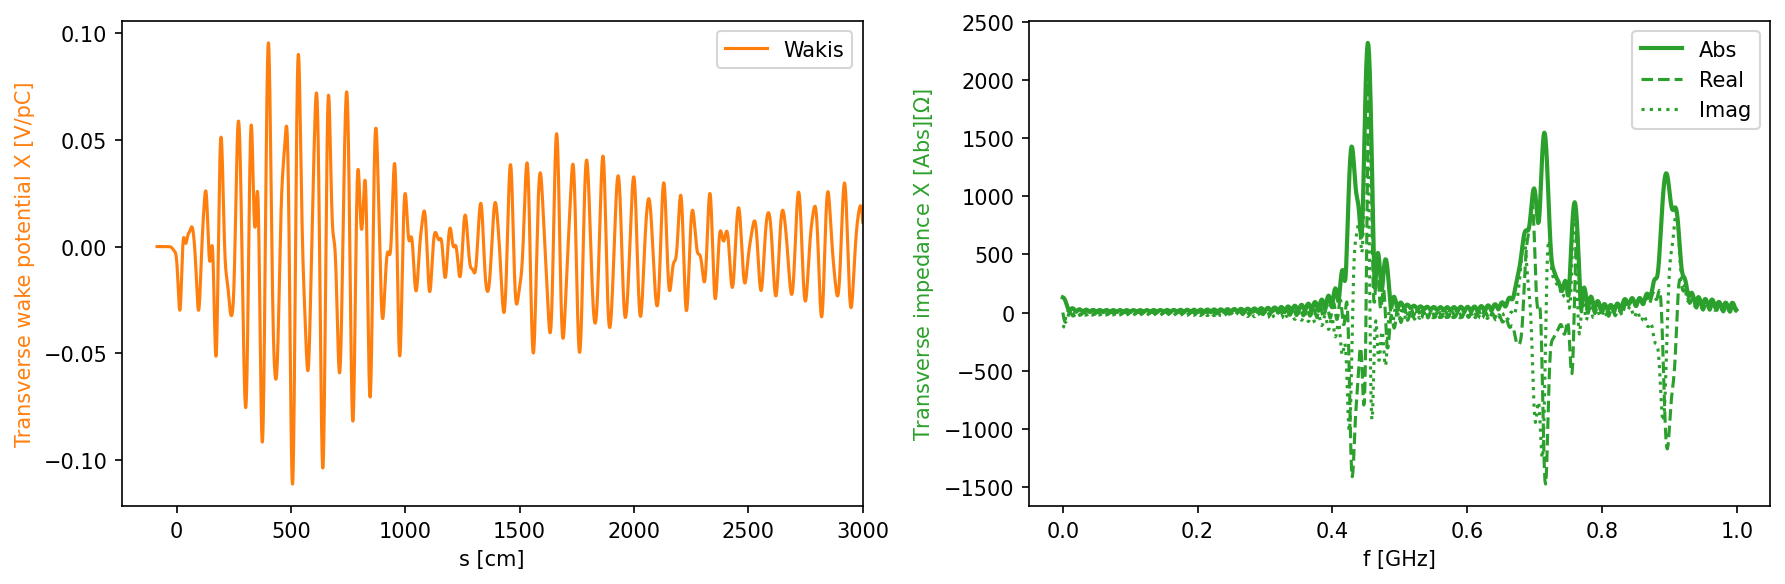

In [ ]:
%%px
if rank == 0:
    # Plot transverse x wake potential and impedance
    fig2, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
    ax[0].plot(wake.s*1e2, wake.WPx, c='tab:orange', lw=1.5, label='Wakis')
    ax[0].set_xlabel('s [cm]')
    ax[0].set_ylabel('Transverse wake potential X [V/pC]', color='tab:orange')
    ax[0].legend()
    ax[0].set_xlim(xmax=wakelength*1e2)

    ax[1].plot(wake.f*1e-9, np.abs(wake.Zx), c='tab:green', lw=2, label='Abs')
    ax[1].plot(wake.f*1e-9, np.real(wake.Zx), c='tab:green', ls='--', lw=1.5, label='Real')
    ax[1].plot(wake.f*1e-9, np.imag(wake.Zx), c='tab:green', ls=':', lw=1.5, label='Imag')
    ax[1].set_xlabel('f [GHz]')
    ax[1].set_ylabel('Transverse impedance X [Abs][$\Omega$]', color='tab:green')
    ax[1].legend()

    fig2.tight_layout()
    fig2.savefig(results_folder+'001_transverse_x.png')
    #plt.show()`

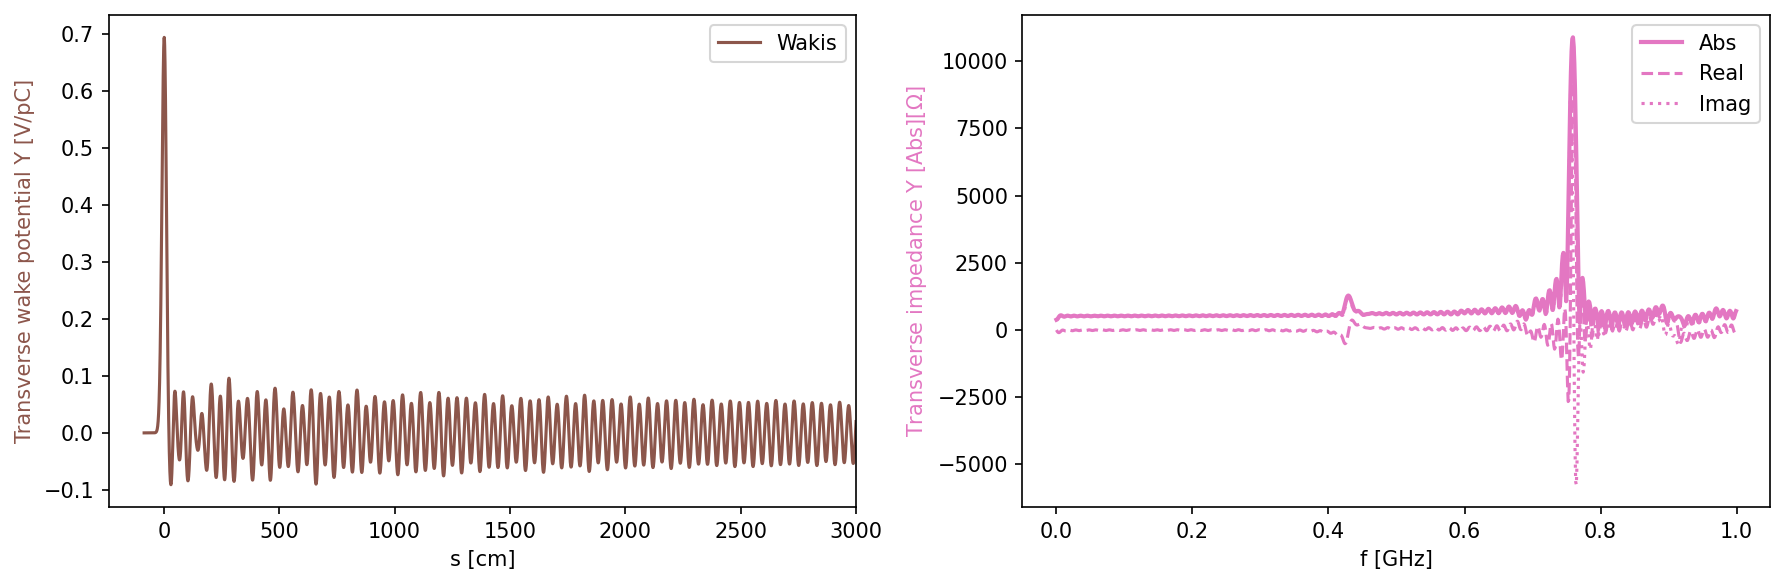

In [ ]:
%%px
if rank == 0:
    # Plot transverse y wake potential and impedance
    fig3, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
    ax[0].plot(wake.s*1e2, wake.WPy, c='tab:brown', lw=1.5, label='Wakis')
    ax[0].set_xlabel('s [cm]')
    ax[0].set_ylabel('Transverse wake potential Y [V/pC]', color='tab:brown')
    ax[0].legend()
    ax[0].set_xlim(xmax=wakelength*1e2)

    ax[1].plot(wake.f*1e-9, np.abs(wake.Zy), c='tab:pink', lw=2, label='Abs')
    ax[1].plot(wake.f*1e-9, np.real(wake.Zy), c='tab:pink', ls='--', lw=1.5, label='Real')
    ax[1].plot(wake.f*1e-9, np.imag(wake.Zy), c='tab:pink', ls=':', lw=1.5, label='Imag')
    ax[1].set_xlabel('f [GHz]')
    ax[1].set_ylabel('Transverse impedance Y [Abs][$\Omega$]', color='tab:pink')
    ax[1].legend()

    fig3.tight_layout()
    fig3.savefig(results_folder+'transverse_y.png')
    #plt.show()

### Plotting the fields
The built-in plotting routines `plot2D` and `plot1D` do not need the rank==0 if statement since it is handled inside

[output:0]

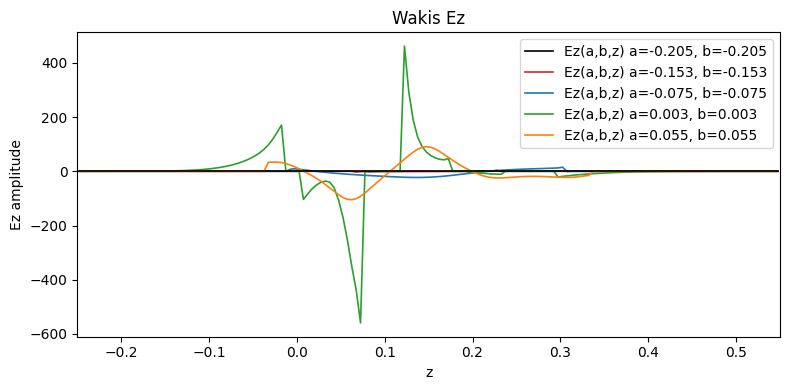

In [16]:
%%px
# %matplotlib ipympl
# Plot Electric field component in 2D using imshow
solver.plot1D(field='E', component='z', 
              line='z', pos=[0.1, 0.2, 0.35, 0.5, 0.6], 
              xscale='linear', yscale='linear',
              off_screen=False, title=results_folder+'Ez1d')

[output:0]

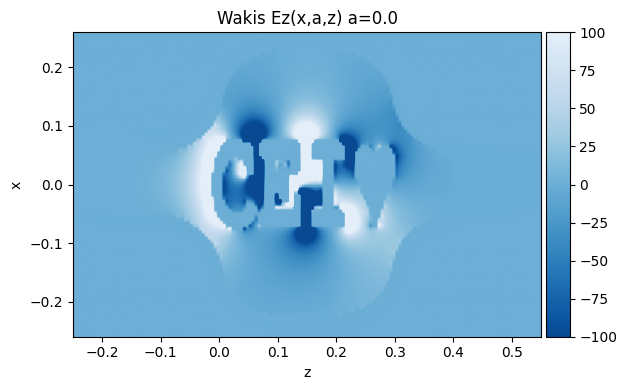

In [18]:
%%px
# ----------- 2d plots results --------------------
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('name', plt.cm.Blues_r(np.linspace(0.1, 0.9))) # CST's colormap

# Plot Electric field component in 2D using imshow
solver.plot2D(field='E', component='z', 
              plane='ZX', pos=0.5, 
              cmap=cmap, vmin=-100, vmax=100., interpolation='hanning',
              add_patch='cavity', patch_reverse=True, patch_alpha=0.8, 
              off_screen=False)

In [19]:
%%px
# TODO: add mpi support for save_state
#    solver.save_state(results_folder+'saved_state.h5')